In [ ]:
#***************************______________**************************************************

!pip install ordered_set # skip if already installed

#***************************______________*********************************************

In [112]:
from selenium.webdriver.chrome.service  import Service
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

from bs4 import BeautifulSoup
import json
import pandas as pd
import time

from ordered_set import OrderedSet
import heapq


In [119]:
service = Service()
driver = webdriver.Chrome(service = service)

# Login In to your Instagram Handle

In [120]:

driver.get("https://www.instagram.com")

time.sleep(3)


#log in
userNameInput = driver.find_element("name","username")
userNameInput.send_keys("SAMPLE USERNAME")

passwordInput = driver.find_element("name","password")
passwordInput.send_keys("SAMPLE PASSWORD")
                        

loginButton = [i for i in driver.find_elements("tag name","button")
   if(i.text=="Log in")
][0]

loginButton.click()    
time.sleep(8.5)


# disable notifications (notifications alert)
driver.get("https://www.instagram.com")
time.sleep(2.5)
disableNotification = driver.find_element('xpath','/html/body/div[3]/div[1]/div/div[2]/div/div/div/div/div[2]/div/div/div[3]/button[2]')
disableNotification.click()


# 1.
## &nbsp;&emsp;     part(1) :-Opens the first 10 handles when any keyword is searched and finds top 5 which have highest number of followers

In [121]:
def getFirstNHandles(n,keyword):
    
    # find and click search icon
    searchIcon = driver.find_element('xpath','/html/body/div[2]/div/div/div[2]/div/div/div/div[1]/div[1]/div[1]/div/div/div/div/div[2]/div[2]/span/div/a')
    searchIcon.click()

    # search keyword
    searchInput = [ i for i in driver.find_elements('tag name','input')
    if i.get_attribute("placeholder")=='Search'
    ][0]
    searchInput.send_keys(keyword)
    time.sleep(2)
    
    # find suggestionList
    suggestionList = WebDriverWait(driver,20).until(EC.visibility_of_element_located(("xpath",'/html/body/div[2]/div/div/div[2]/div/div/div/div[1]/div[1]/div[1]/div/div/div[2]/div/div/div[2]/div/div/div[2]')))
    suggestionsHtml = suggestionList.get_attribute('outerHTML') #get html of suggestionList

    #parse suggestion list html with Beautifule soup
    data = BeautifulSoup(suggestionsHtml,'html.parser')

    # fetch handle names webelement
    handleNames = data.select('a div:nth-child(1)>div>div>div:nth-child(2)>div>div:nth-child(1)')[0:n]

    
    
    # stores handle names in handles list
    handles = []

    for i in handleNames:

        x = i.select('span:nth-child(1)')
        if(x[0].get_text()[0]!="#"):
            handles.append(i.select('span')[0].get_text())
            
    return handles


In [122]:
def openProfile(userName):
    
    base_url = 'https://www.instagram.com'
    driver.get(base_url+'/'+userName+'/')


In [123]:
def getFollowers(userName):
    openProfile(userName) # open user profile
    time.sleep(5.2)
    
    # get number of followers
    followers = driver.find_element('partial link text','followers').text.strip(' followers')
    
    
    
    # convert followers into float
    
    followers = followers.replace(',','')
    
    s = len(followers)
    if(followers[s-1]=='K'):
        followers = float(followers[0:s-1])*1000
    elif(followers[s-1]=='M'):
        followers = float(followers[0:s-1])*1000000


    return float(followers)


In [124]:
def getFollowersOfHandles(handles):
    
    dic = {}
    
    # iterate over each handle and call getFollowers(), store value returned in dic
    for handle in handles:       
        dic[handle] = getFollowers(handle)
        
    return dic
    

In [125]:
handles = getFirstNHandles(10,'food')  # get first 10 handles when keyword 'food' is searched
followersDic = getFollowersOfHandles(handles) #get followers of these handles
followersDic = dict(sorted(followersDic.items(),key= lambda x:x[1],reverse=True)[0:5]) # get top 5 handles having max followers

print(followersDic)


{'dilsefoodie': 1100000.0, 'foodpharmer': 1100000.0, 'foodies_findings': 766000.0, 'foodpandits': 357000.0, 'foodtalkindia': 309000.0}


## part2. Number of posts these handles have done in preveious 3 days

In [126]:
def countPostsInLast3Days(userName):
    
    openProfile(userName) # open handle
    time.sleep(2.5)

    # get posts_container
    posts_container = WebDriverWait(driver,20).until(EC.visibility_of_element_located(('tag name','article'))) 
    
    #get all posts in posts_container web element
    posts =WebDriverWait(posts_container,10).until(EC.presence_of_all_elements_located(('tag name','a')))
    posts_count = len(posts) # no. of posts
    
    i= 0
    count = 0
    
    while i<posts_count:
        
        pinned = False # checks if post is pinned or unpinned
        
        try:
            
            # if post is pinned make pinned true
            if posts[i].find_element('tag name','svg').get_attribute('aria-label')=='Pinned post icon':
                pinned = True
                 
        except NoSuchElementException : # if unpinned
            pinned = False
        
        #open ith post
        posts[i].click()
        time.sleep(1.5)
        
        #store posted time
        postedTime = driver.find_elements('tag name','time')[-1].text.split(' ')
        
        # if posted in previous 3 days increment count
        if('SECOND' in postedTime[1] or 'MINUTE' in postedTime[1] or 'HOUR' in postedTime[1] or ('DAY' in postedTime[1] and int(postedTime[0])<=3)):
            count+=1
        elif not pinned: #if posted before last 3days and not pinned break loop
            break
            
        driver.back() #return to previous page
        
        i+=1
        
        if i==posts_count:  # if all posts in posts_container webelement are traversed , add newly loaded posts in posts list
            posts =WebDriverWait(posts_container,10).until(EC.visibility_of_all_elements_located(('tag name','a')))
            posts_count=len(posts) # update posts_count
            
    return count


In [127]:
def getNoOfPostsInLast3Days(handles):
    
    dic = {}
    
    # store no. of posts added in last 3 days in dic ,of each handle
    for handle in handles:
        dic[handle] = countPostsInLast3Days(handle)
        
    return dic


In [128]:
recentPostsDic = getNoOfPostsInLast3Days(list(followersDic.keys())) # call getNoOfPostsInLast3Days() and pass keys of followers dic as argument (these keys refer to top 5 handles having most followers ,(obtained when keyword food is searched))
print(recentPostsDic)

{'dilsefoodie': 7, 'foodpharmer': 2, 'foodies_findings': 8, 'foodpandits': 8, 'foodtalkindia': 5}


# part3. Plotting graph

In [129]:
import matplotlib.pyplot as plt

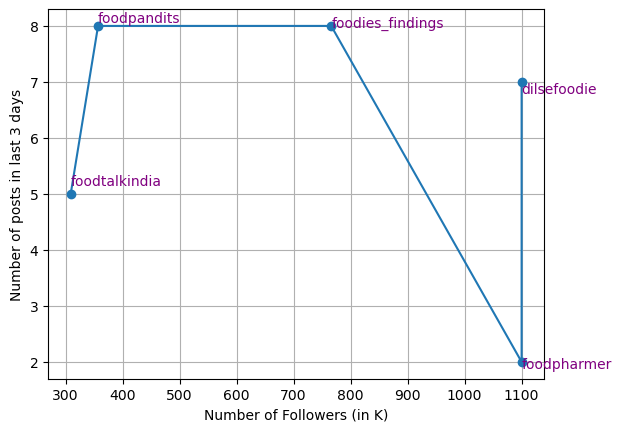

In [130]:

followers = [i/1000 for i in (followersDic.values())]  # store followers in followers list (convert unit to k , by dividing followers by 1000)
recentPostsCount = list(recentPostsDic.values())  # store no. of posts in last in 3days of handles whom these followers belongs in list recentPostsCount

#plot the graph
plt.plot(followers,recentPostsCount,marker='o')
plt.grid()

plt.xlabel('Number of Followers (in K)')
plt.ylabel('Number of posts in last 3 days')


# ________ write usernames in graph__________

z =-0.2      #used to change position of userName in graph to avoid collision of usernames

for userName in followersDic.keys():
    x = int(followersDic[userName]/1000)
    y = recentPostsDic[userName]
    
    plt.text(x,y+z,userName,color='purple')
    z+=0.09

plt.show()

# 2.

# part(1):- Opening 5 handles obtained in last ques and scraping content of first 10 posts of each handle

In [131]:
def getContentOfFirstNPosts(n,userName,contentList):
    openProfile(userName) #open handle
    time.sleep(2.5)
    
    # get posts_container
    posts_container = WebDriverWait(driver,20).until(EC.visibility_of_element_located(('tag name','article'))) 
    
    #get all posts in posts_container web element
    posts =WebDriverWait(posts_container,10).until(EC.presence_of_all_elements_located(('tag name','a')))
    posts_count = len(posts) # no. of posts
    
    
    i = 0
    
    #iterate over each post
    while(i<10 and i<posts_count):
        #open ith post
        posts[i].click()
        time.sleep(1.5)
        
        
        # get post content and store it in contentList
        content = driver.find_element('class name','_a9zs').text
        content = content.replace('\n',' ')
        contentList.append(content)
        
        
        driver.back()#return to previous page
        
        i+=1;
     
        
        if i==posts_count: # if all posts in posts_container webelement are traversed , add newly loaded posts in posts list
            time.sleep(0.5)
            posts =posts + WebDriverWait(posts_container,10).until(EC.presence_of_all_elements_located(('tag name','a')))
            posts = list(OrderedSet(posts))
            posts_count=len(posts) # update posts_count


In [132]:
contentList = []
handles = list(followersDic.keys())
n=10
for handle in handles:
    getContentOfFirstNPosts(n,handle,contentList)


print(contentList)

["#Ad Garmi ka Mausam aa gaya hai, toh matlab naya ice cream flavour toh try karna chahiye! 😍 Tried the @kwalitywalls new Hazelnut Chocolate Ice cream and it has just the right amount of sweetness. Go check it out! Order yours on Swiggy or get it from your nearest Kwality Wall's freezer! #CraftedForIndulgence #IceCream #Hazelnuts #Chocolate #hazelnutchocolate #dilsefoodie", '24 Haree Mirch And 15 Nimbu Daal Ke Banaye Hai Chacha Bhatija Special Chole Kulche 😂😂. Thanks To @agraeaters For Helping Us Exploring Agra Street Food. #dilsefoodie #food #streetfood #cholekulche', "On The Occasion Of 75th Independence Day @ministryofculturegoi Awarded Us As One Of 75 Cultural Brand Ambassador Of India At @amritmahotsav.  We Can't Express Our Feelings In Words. But We Will Promise You Guys We Will Keep Exploring India And Will Help Local Vendors.  Government Of India Is Doing A Campaign #harghartiranga So I Will Hoist Tiranga At My Place Tomorrow And You Guys Also Participate. #75For75 #amritmohats

# part(2):- prepare list of all words used in all the scraped posts and calculate frequency of each word

In [133]:
wordFreq = {}

for content in contentList:
    
    words = content.split(' ')
    
    for word in words:
        wordFreq[word] = wordFreq.get(word,0)+1

        
print(wordFreq)

{'#Ad': 2, 'Garmi': 1, 'ka': 1, 'Mausam': 1, 'aa': 1, 'gaya': 1, 'hai,': 1, 'toh': 2, 'matlab': 1, 'naya': 1, 'ice': 1, 'cream': 2, 'flavour': 1, 'try': 3, 'karna': 1, 'chahiye!': 1, '😍': 5, 'Tried': 2, 'the': 71, '@kwalitywalls': 1, 'new': 2, 'Hazelnut': 1, 'Chocolate': 4, 'Ice': 1, 'and': 53, 'it': 18, 'has': 1, 'just': 4, 'right': 3, 'amount': 2, 'of': 53, 'sweetness.': 1, 'Go': 1, 'check': 3, 'out!': 1, 'Order': 2, 'yours': 1, 'on': 13, 'Swiggy': 1, 'or': 5, 'get': 6, 'from': 14, 'your': 17, 'nearest': 1, 'Kwality': 1, "Wall's": 1, 'freezer!': 1, '#CraftedForIndulgence': 1, '#IceCream': 1, '#Hazelnuts': 1, '#Chocolate': 1, '#hazelnutchocolate': 1, '#dilsefoodie': 10, '24': 1, 'Haree': 1, 'Mirch': 1, 'And': 8, '15': 2, 'Nimbu': 1, 'Daal': 1, 'Ke': 2, 'Banaye': 1, 'Hai': 1, 'Chacha': 1, 'Bhatija': 1, 'Special': 2, 'Chole': 2, 'Kulche': 1, '😂😂.': 1, 'Thanks': 1, 'To': 6, '@agraeaters': 1, 'For': 6, 'Helping': 1, 'Us': 2, 'Exploring': 2, 'Agra': 3, 'Street': 3, 'Food.': 1, '#food': 14,

# part(3):- Create csv file with two columns: the word and its frequency

In [134]:
df = pd.DataFrame(list(wordFreq.items()))
df.columns = ['words','frequency']
df.to_csv('wordFreq.csv',index=False)

# part(4):- Find hashtags that were most popular among these bloggers

In [135]:
hashTagsDf = df[df['words'].str.startswith('#')]
hashTagsDf.reset_index(inplace=True,drop=True)
top5hashTags = hashTagsDf.nlargest(5,['frequency']).reset_index(drop=True)
top5hashTags.head()

,words,frequency
0,#foodstagram,18
1,#instafood,17
2,#food,14
3,#foodgasm,14
4,#foodpandits,11


# part(5):- Plot pie chart of top 5 hashtags obtained and no. of times they were used by these bloggers in the scraped posts

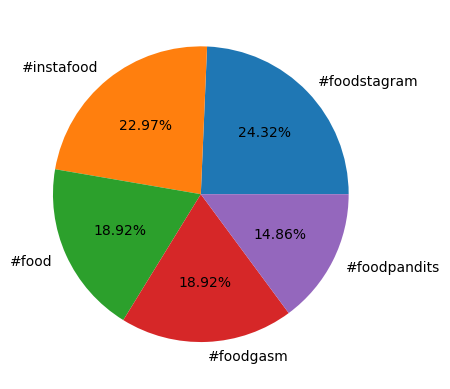

In [136]:
hashtags = list(top5hashTags['words'])
frequency = list(top5hashTags['frequency'])

plt.pie(frequency,labels=hashtags,autopct="%.2f%%")

plt.show()


# 3. Calculate average followers : likes ratio

In [137]:
def getLikes(userName):            
    
    openProfile(userName) # open handle
    time.sleep(2.5)

    # get posts_container
    posts_container = WebDriverWait(driver,20).until(EC.visibility_of_element_located(('tag name','article'))) 
    #get all posts in posts_container web element # no. of posts
    posts =WebDriverWait(posts_container,10).until(EC.presence_of_all_elements_located(('tag name','a')))
    posts_count = len(posts) # no. of posts
    
    
    totalLikes = 0 # stores sum of likes of first 10 posts of a handle
    
    i = 0
    #iterate over first 10 post
    while(i<posts_count and i<10):
         #open ith post
        posts[i].click()
        time.sleep(1.5)
        
        try:
            
            #fetch no. of likes and convert it into integer
            likes = driver.find_element('class name','_ae5m').find_element('class name','html-span').text.split(' ')[0]
            likes = likes.replace(',','')
            likes = int(likes)
            
            totalLikes+=likes # add likes in totalLikes

        except NoSuchElementException :
            pass
      
        driver.back()#return to previous page
        
        i+=1;
        
        if i==posts_count:  # if all posts in posts_container webelement are traversed , add newly loaded posts in posts list
            time.sleep(0.5)
            posts =posts + WebDriverWait(posts_container,10).until(EC.presence_of_all_elements_located(('tag name','a')))

            posts = list(OrderedSet(posts))
            posts_count=len(posts) # update posts_count
            
            
    return totalLikes


In [138]:
def getHandlesTop10PostLikes(handles):
    
    dic = {}
    
   # iterate over each handle and call getLikes, store result in dic
    for handle in handles:
        dic[handle] = getLikes(handle) # calculating average likes of a handle (part2)
        
    return dic


# part(1):- find out likes of top 10 posts of handles obtained earlier

In [139]:
likesDic = getHandlesTop10PostLikes(handles) # fetch sum of likes of top 10 posts of handles
print(likesDic)

{'dilsefoodie': 546474, 'foodpharmer': 3686214, 'foodies_findings': 314803, 'foodpandits': 2393823, 'foodtalkindia': 2196}


# part(2):- Calculate average likes 

In [140]:
averageLikesDic = {}

# calcuate average likes for each handle
for handle in likesDic.keys():
    averageLikesDic[handle] = likesDic[handle]/10
    
print(averageLikesDic)

{'dilsefoodie': 54647.4, 'foodpharmer': 368621.4, 'foodies_findings': 31480.3, 'foodpandits': 239382.3, 'foodtalkindia': 219.6}


# part 3:- Divide average likes obtained from the number of followers of the handle to get the average followers:like ratio of each handle

In [141]:
avgFollowersLikeRatio = {}
# calculate ratio, average followers:like 
for handle in handles:
    
    avgFollowersLikeRatio[handle] = followersDic[handle]/averageLikesDic[handle]
    
print(avgFollowersLikeRatio)


{'dilsefoodie': 20.129045480663308, 'foodpharmer': 2.9840915367366083, 'foodies_findings': 24.332677896970488, 'foodpandits': 1.4913383320320677, 'foodtalkindia': 1407.1038251366122}


# part(4):- Create bar graph to depict obtained information

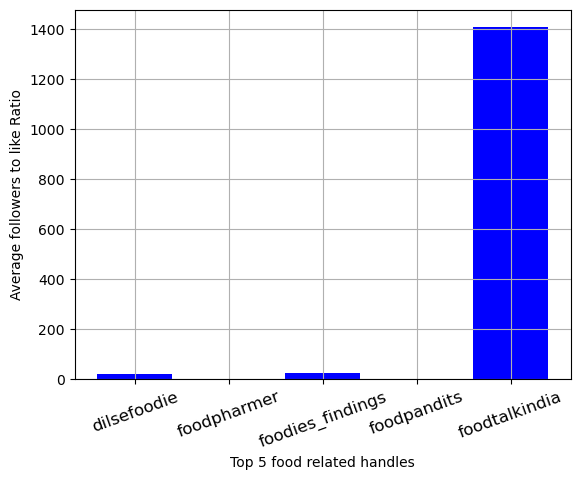

In [142]:
ratio = list(avgFollowersLikeRatio.values())
handles = list(avgFollowersLikeRatio.keys())

plt.bar(handles,ratio,color='blue')
plt.xlabel('Top 5 food related handles')
plt.ylabel('Average followers to like Ratio')
plt.xticks(rotation=20, size=12)
plt.grid()

plt.show()